In [1]:
import pandas as pd
from sqlalchemy import create_engine
import pandasql as ps
import os
from urllib.parse import quote_plus

import plotly.express as px

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
db_address = os.getenv('DB_ADDRESS', 'localhost')
db_user = os.getenv('DB_USER', 'username')
db_password = quote_plus(os.getenv('DB_PASSWORD', '111222'))
db_name = os.getenv('DB_NAME', 'dwh')

In [4]:
db_url = f'postgresql://{db_user}:{db_password}@{db_address}/{db_name}'
db_engine = create_engine(db_url)

# EDA

> In those samples of code we will concentrate analytics on **sUSD/3CRV** gauge on [Convex](https://www.convexfinance.com/), but the current ETL Architecture may provide more flexible configuration such as web-UI with dynamic variables to choose certain chain, protocol and pool for analysis, for example on the same [Convex.finance](https://www.convexfinance.com/)

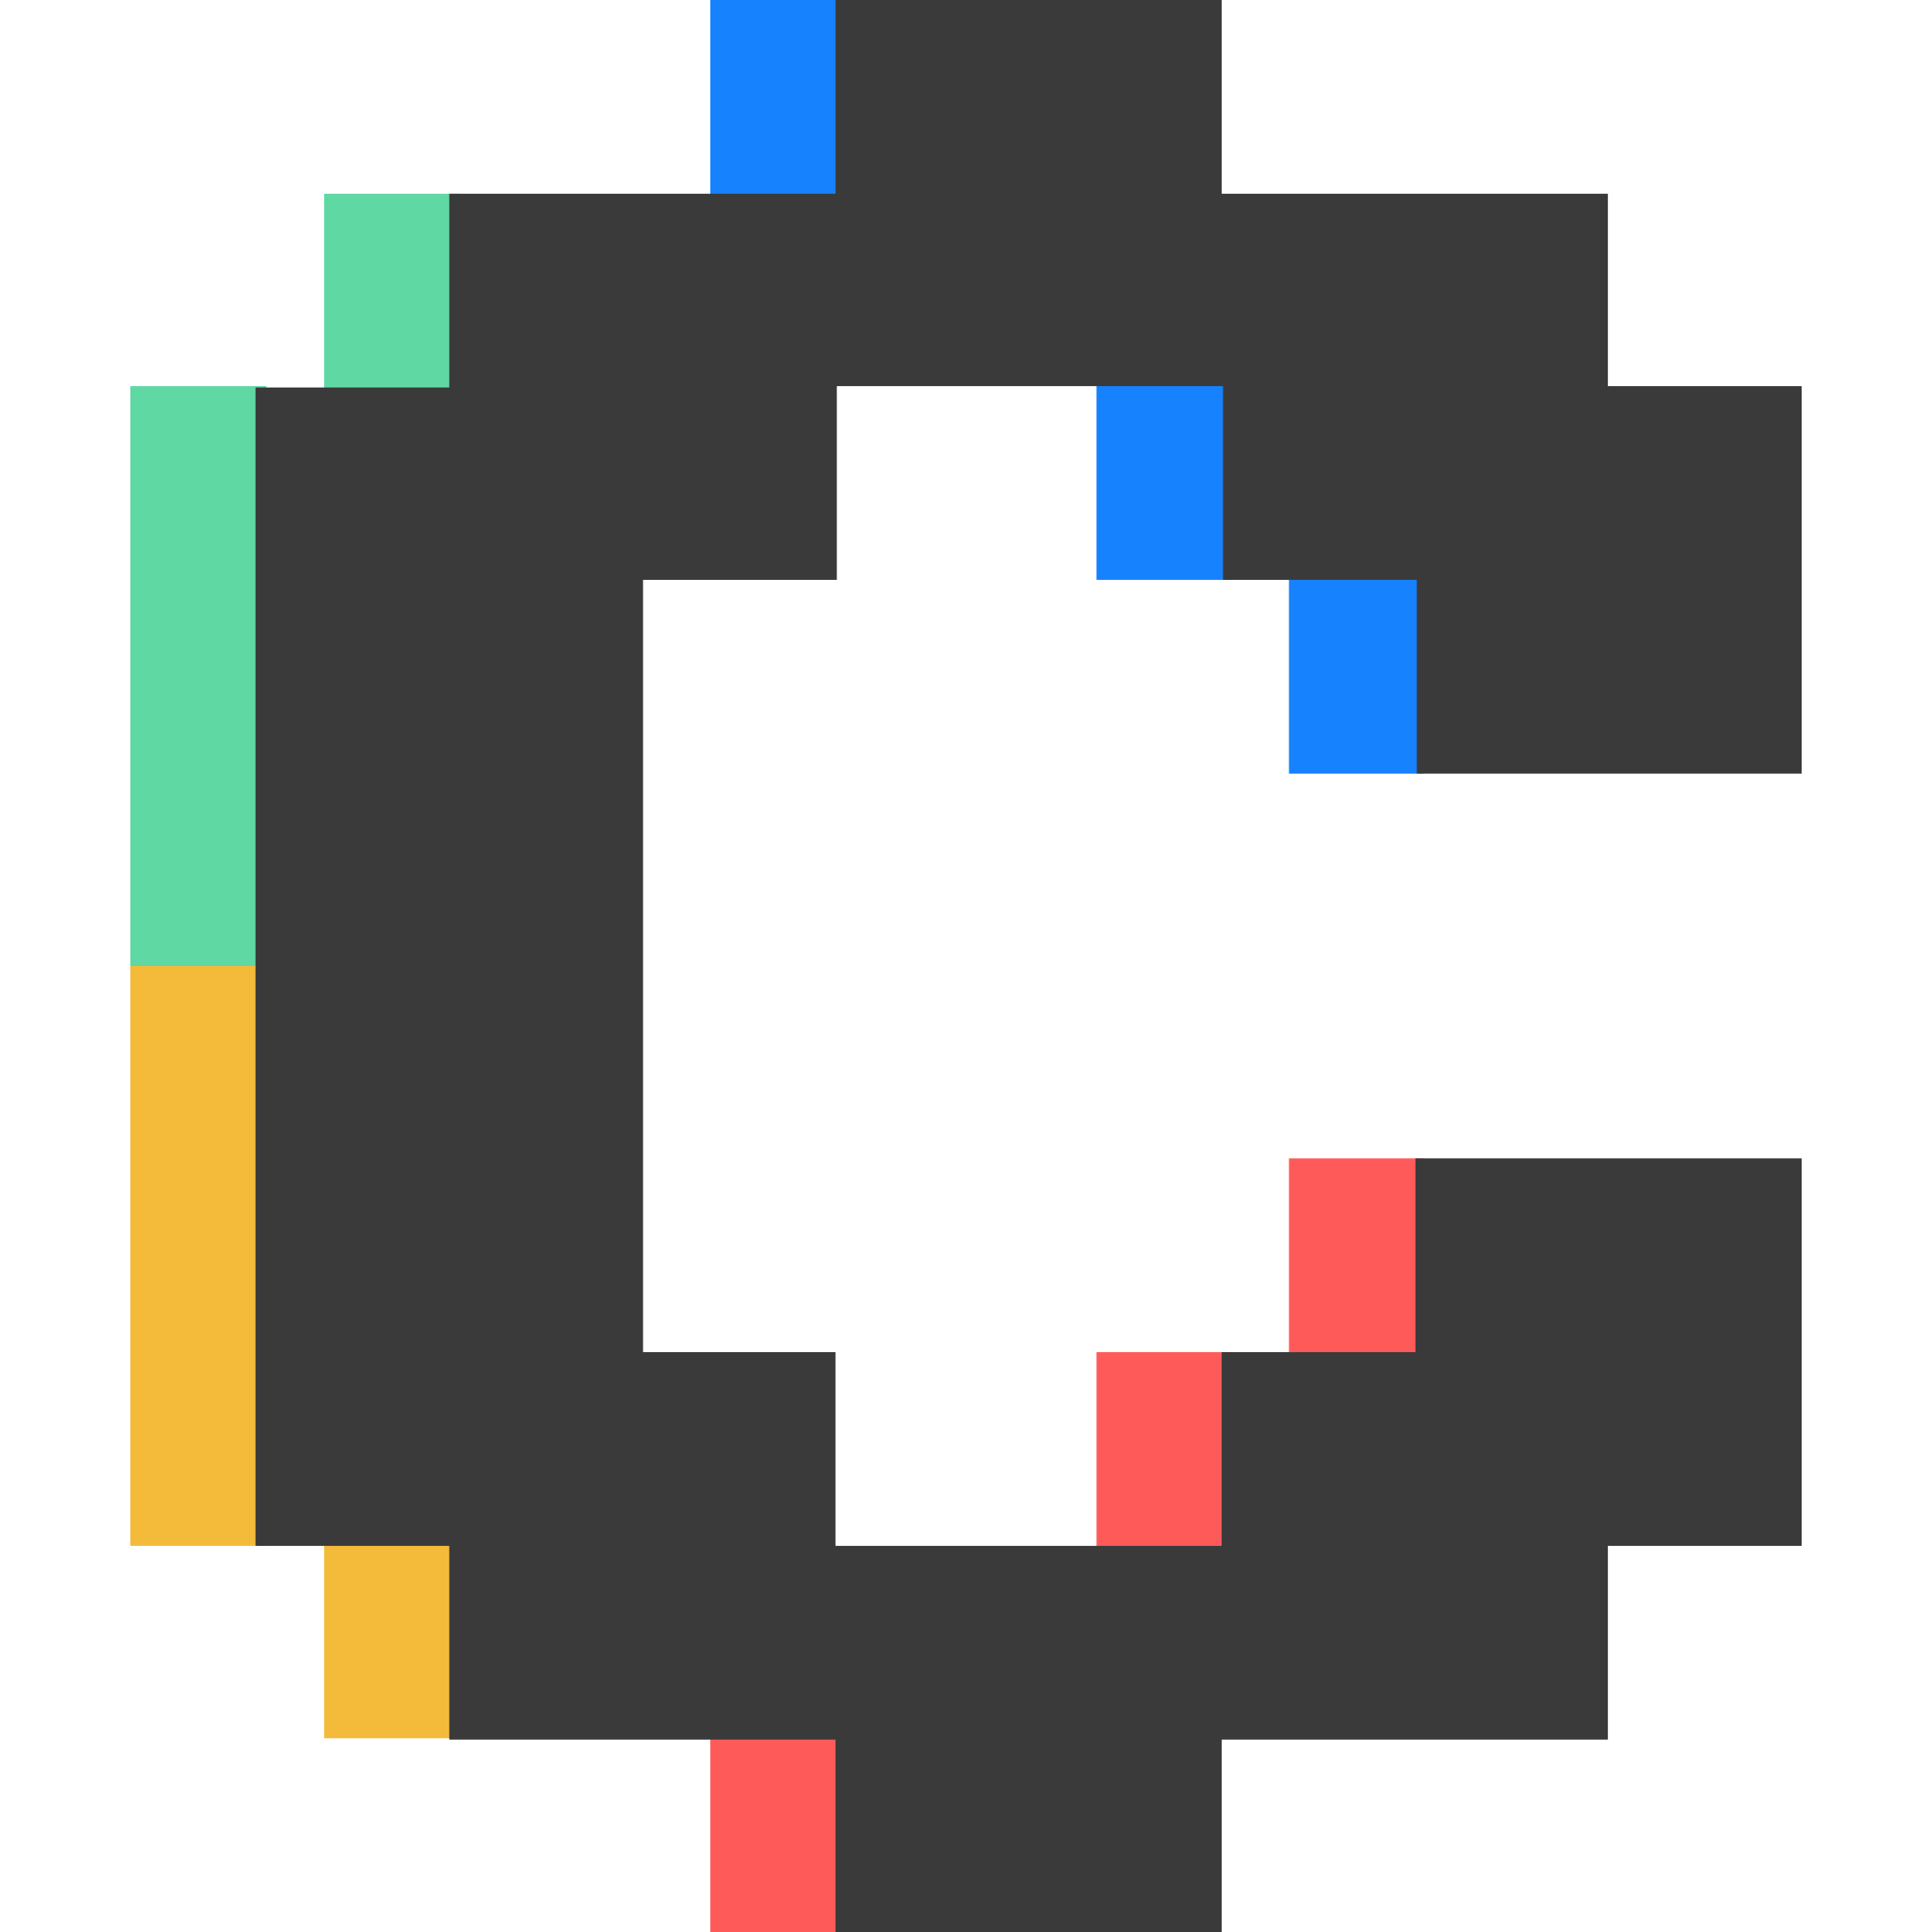

In [5]:
# current 3CRV pool ID in DWH
l_address_protocol_chain_id = 3

In [6]:
l_address_protocol_chain_prefix = 'staking-pool-overview'

In [20]:
query = f'''
    SELECT
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_staking_pool_overview.pit_token_symbol,
        SUM(pit_staking_pool_overview.pit_token_reserve * pit_staking_pool_overview.pit_token_price)
            OVER(
                PARTITION BY 
                    l_addresses_protocols_chains.l_address_protocol_chain_id,
                    pit_staking_pool_overview.pit_token_symbol,
                    DATE_TRUNC('minute', pit_staking_pool_overview.pit_liquidity_pool_overview_load_ts)
            ) as "pit_token_amount",
        DATE_TRUNC('minute', pit_staking_pool_overview.pit_liquidity_pool_overview_load_ts)
    FROM pit_staking_pool_overview
    LEFT JOIN l_addresses_protocols_chains USING(l_address_protocol_chain_id)
    LEFT JOIN l_addresses_chains USING(l_address_chain_id)
    LEFT JOIN l_protocols_chains USING(l_protocol_chain_id)
    LEFT JOIN h_protocols USING(h_protocol_id)
    LEFT JOIN h_chains ON l_addresses_chains.h_chain_id = h_chains.h_chain_id
    WHERE
        l_addresses_protocols_chains.l_address_protocol_chain_id = {l_address_protocol_chain_id} and
        l_addresses_protocols_chains.l_address_protocol_chain_prefix = '{l_address_protocol_chain_prefix}'
    GROUP BY
        l_addresses_protocols_chains.l_address_protocol_chain_id,
        DATE_TRUNC('minute', pit_staking_pool_overview.pit_liquidity_pool_overview_load_ts),
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_staking_pool_overview.pit_token_symbol,
        pit_staking_pool_overview.pit_token_reserve,
        pit_staking_pool_overview.pit_token_price
    ORDER BY 
        DATE_TRUNC('minute', pit_staking_pool_overview.pit_liquidity_pool_overview_load_ts),
        l_addresses_protocols_chains.l_address_protocol_chain_id
'''

In [21]:
df = pd.read_sql_query(sql=query, con=db_engine)
df.head()

,l_address_chain_name,h_protocol_name,h_network_name,pit_token_symbol,pit_token_amount,date_trunc
0,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,79658407.249,2022-09-11 23:13:00
1,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,79658407.249,2022-09-11 23:18:00
2,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,79658407.249,2022-09-11 23:23:00
3,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,79658407.249,2022-09-11 23:28:00
4,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,79658420.306,2022-09-11 23:33:00


In [22]:
px.line(
    df, 
    x="date_trunc", 
    y="pit_token_amount",
    title='sUSD/3CRV Staking Pool TVL'
)

> The only data which can be extracted from Staking Pools is a **TVL** and **Staking LP token price**

In [23]:
query = f'''
    SELECT
        l_addresses_chains.l_address_chain_name,
        h_protocols.h_protocol_name,
        h_chains.h_network_name,
        pit_staking_pool_overview.pit_token_symbol,
        pit_staking_pool_overview.pit_token_price,
        DATE_TRUNC('minute', pit_staking_pool_overview.pit_liquidity_pool_overview_load_ts)
    FROM pit_staking_pool_overview
    LEFT JOIN l_addresses_protocols_chains USING(l_address_protocol_chain_id)
    LEFT JOIN l_addresses_chains USING(l_address_chain_id)
    LEFT JOIN l_protocols_chains USING(l_protocol_chain_id)
    LEFT JOIN h_protocols USING(h_protocol_id)
    LEFT JOIN h_chains ON l_addresses_chains.h_chain_id = h_chains.h_chain_id
    WHERE
        l_addresses_protocols_chains.l_address_protocol_chain_id = {l_address_protocol_chain_id} and
        l_addresses_protocols_chains.l_address_protocol_chain_prefix = '{l_address_protocol_chain_prefix}'
    ORDER BY 
        DATE_TRUNC('minute', pit_staking_pool_overview.pit_liquidity_pool_overview_load_ts),
        l_addresses_protocols_chains.l_address_protocol_chain_id
'''

In [24]:
df = pd.read_sql(sql=query, con=db_engine)
df.head()

,l_address_chain_name,h_protocol_name,h_network_name,pit_token_symbol,pit_token_price,date_trunc
0,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,1.057,2022-09-11 23:13:00
1,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,1.057,2022-09-11 23:18:00
2,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,1.057,2022-09-11 23:23:00
3,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,1.057,2022-09-11 23:28:00
4,sUSD/3CRV Gauge,Convex,eth,cvxcrvPlain3andSUSD,1.057,2022-09-11 23:33:00


In [25]:
px.line(
    df, 
    x="date_trunc", 
    y="pit_token_price",
    title='sUSD/3CRV LP price'
)

> **Staking LP token price** :)